In [ ]:
# ***You need to run these GEE script for your state first***
# https://code.earthengine.google.com/935e3840bd5a63f1e40097b1f0c6ad45
#https://code.earthengine.google.com/b5d49bb675cc2d6583e866dc1dfb440b
# 

In [1]:
# User defined variables
my_training_state = 'MN' # State USPS abbreviation
state_name = 'Minnesota'
my_nas_id = 5
# IA = 19; ID = 16; IL = 17; MN = 27; MO = 29; MT = 30; OR = 41;  WA = 53; WI = 55
state_fips = '27'
state_fip = 'US%3A'+ state_fips # Replace last 2 digits with your state's FIP code
my_path = 'data/' + my_training_state + '/' # leave this alone   

In [2]:
# Core Libraries
import os
import json
import glob
import zipfile
import random
import io
from io import StringIO, BytesIO

# Data Handling
import pandas as pd
import numpy as np

# Geospatial Libraries
import geopandas as gpd
import folium
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.mask import mask
import rasterio.plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
from affine import Affine
import networkx as nx
from shapely.geometry import Point, LineString
from shapely.ops import snap, nearest_points

# Machine Learning & Statistical Modeling
import sklearn as skl
from sklearn.neighbors import KDTree, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import gaussian_process

# Geostatistics & Interpolation
import skgstat as skg
import gstools as gs
from skgstat import models
from skgstat.util.likelihood import get_likelihood
import scipy
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
from scipy.spatial import cKDTree
from scipy.interpolate import NearestNDInterpolator
import scipy.ndimage
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

# Visualization
import matplotlib.pyplot as plt

# APIs & Requests
import requests
from pygbif import occurrences as occ
from pygbif import species


In [3]:
#Helper functions for water chemistry interpolation and biodiversity predictors
def get_station_data(state):
    URL_BASE_2 = 'https://www.waterqualitydata.us/data/Station/search?'
    url_request_2 = f"{URL_BASE_2}countrycode=US&statecode={state}"
    response_2 = pd.read_csv(url_request_2)
    return response_2
def find_nearest(row, other_gdf):
    # Find the index of the nearest geometry
    nearest_idx = other_gdf.distance(row.geometry).idxmin()
    return other_gdf.loc[nearest_idx]

def add_nearest(gdf1, gdf2):
    nearest_neighbors = gdf1.apply(lambda row: find_nearest(row, gdf2), axis=1)
    # Add nearest neighbor information to the first GeoDataFrame
    gdf1['nearest_id'] = nearest_neighbors['station_id']
    gdf1['median'] = nearest_neighbors['median']
    parameter_added = gdf1
    return parameter_added

def get_data(state, characteristic, my_format):
    URL_BASE = 'https://www.waterqualitydata.us/data/Result/search?'
    url_request = f"{URL_BASE}countrycode=US&statecode={state}&characteristicName={characteristic}&mimeType={my_format}"
    response = pd.read_csv(url_request)
    return response

def interpolate(stations_w_data, filename, bandname="Interpolated_Band", max_grid_size=500):
    # Extract coordinates and values
    stations_w_data = stations_w_data.to_crs(5070)
    stations_w_data['x'] = stations_w_data.geometry.x
    stations_w_data['y'] = stations_w_data.geometry.y
    samples_df = stations_w_data[['x', 'y', 'median']]
    x_point = samples_df['x']
    y_point = samples_df['y']
    coords = np.column_stack((x_point, y_point))
    vals = samples_df['median']
    
    # Scatter plot of original data
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    art = ax.scatter(coords[:, 0], coords[:, 1], s=10, c=vals, cmap='plasma', vmin=0, vmax=vals.max())
    plt.colorbar(art)
    plt.title("Original Data Points")
    plt.show()
    
    # Adaptive grid sizing
    xmin, xmax = x_point.min(), x_point.max()
    ymin, ymax = y_point.min(), y_point.max()
    
    grid_x = min(max_grid_size, int((xmax - xmin) / 500))
    grid_y = min(max_grid_size, int((ymax - ymin) / 500))

    use_kriging = grid_x * grid_y <= 1e6
    
    try:
        if use_kriging:
            print("🔹 Attempting Ordinary Kriging interpolation...")
            
            pairwise_distances = pdist(coords)  # Compute pairwise distances between points
            maxlag = np.median(pairwise_distances)  # Use median distance
            n_lags = min(30, max(10, int(len(coords) / 10)))
            V = skg.Variogram(coords, vals, model='exponential', maxlag=maxlag, n_lags=n_lags, normalize=False)
            ok = skg.OrdinaryKriging(V, min_points=1, max_points=8, mode='exact')
            xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
            field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
            s2 = ok.sigma.reshape(xx.shape)
            print("✅ Kriging completed successfully.")
        else:
            raise MemoryError  
    except (MemoryError, ValueError, np.linalg.LinAlgError):
        print("⚠️ Kriging failed, using Nearest Neighbor interpolation...")
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        knn = KNeighborsRegressor(n_neighbors=min(8, len(coords)), weights='distance', algorithm='kd_tree', n_jobs=-1)
        knn.fit(coords, vals)
        query_points = np.column_stack((xx.ravel(), yy.ravel()))
        field = knn.predict(query_points).reshape(xx.shape)
        s2 = np.zeros_like(field)
        print("✅ Nearest Neighbor interpolation completed.")

    # Fill missing values
    def fill_missing_values(field):
        mask = np.isnan(field)
        if np.all(mask):
            raise ValueError("All values are NaN; interpolation cannot be performed.")
        nearest_indices = scipy.ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
        field[mask] = field[tuple(nearest_indices[i][mask] for i in range(field.ndim))]
        return field

    field = fill_missing_values(field)

    # Export interpolated raster
    nrows, ncols = field.shape
    xres = (xmax - xmin) / float(ncols)
    yres = (ymax - ymin) / float(nrows)
    arr = np.abs(field).astype(np.float32)

    # Ensure array is properly oriented
    arr = np.abs(field.T).astype(np.float32)  # Transpose to fix 90-degree rotation
    
    # Define transform with corrected Y-axis orientation
    transform = from_origin(xmin, ymax, xres, -yres)  # ymax ensures correct vertical alignment
    
    # Export raster
    with rasterio.open(filename, 'w', driver='GTiff',
                       height=arr.shape[0], width=arr.shape[1],  # Ensure correct height/width order
                       count=1, dtype=str(arr.dtype),
                       crs= 5070,
                       transform=transform) as new_dataset:
        new_dataset.write(arr, 1)
        new_dataset.set_band_description(1, bandname)
    
    print(f"✅ Raster saved correctly: {filename}")
    
    # Plot corrected raster
    plt.figure(figsize=(10, 8))
    plt.imshow(arr, extent=[xmin, xmax, ymin, ymax], cmap='plasma', origin="lower")  # Corrected orientation
    plt.colorbar(label=bandname)
    plt.title("Interpolated Raster (Corrected Orientation)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

# This function requests and retrieves the AIS records from the USGS NAS database API
def nas_api_call(state):
    URL_BASE = 'http://nas.er.usgs.gov/api/v2/'
    url_request = f"{URL_BASE}/occurrence/search?state={state}"
    response = requests.get(url_request, timeout=None).json()
    results = pd.json_normalize(response, 'results')
    return results

def make_bg_data(geo_df):    
    species_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']
    existing_columns = [col for col in species_columns if col in geo_df.columns]  
    random_points = []

    # Ensure input is in EPSG:5070
    if geo_df.crs and geo_df.crs != 5070:
        geo_df = geo_df.to_crs(5070)

    for _, row in geo_df.iterrows():
        if not existing_columns or row[existing_columns].sum() == 0:  
            polygon = row.geometry
            if polygon.is_empty or not polygon.is_valid:
                random_points.append(None)
                continue

            minx, miny, maxx, maxy = polygon.bounds

            while True:
                random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
                if polygon.contains(random_point):
                    random_points.append(random_point)
                    break
        else:
            random_points.append(None)

    # Filter out None values before creating GeoDataFrame
    new_gdf = gpd.GeoDataFrame(geometry=[p for p in random_points if p is not None], crs="EPSG:5070")
    
    return new_gdf

# Function to clip point geometries by polygon geometries
def clip_points_by_polygon(points_gdf, polygon_gdf):
    # Ensure that both GeoDataFrames are in the same CRS
    if points_gdf.crs != polygon_gdf.crs:
        points_gdf = points_gdf.to_crs(polygon_gdf.crs)

    # Clip the points with the polygon(s)
    clipped_points = gpd.sjoin(points_gdf, polygon_gdf, how='inner')

    # Drop the geometry from polygon_gdf that was added during the join (if needed)
    clipped_points = clipped_points.drop(columns=polygon_gdf.columns.difference(['geometry']))

    return clipped_points

def sum_numeric_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Identify columns with six-digit string headers
    sum_columns = [col for col in gdf.columns if col.isdigit() and len(col) == 6]
    
    # Sum across these columns
    gdf["Native_Fish_Richness"] = gdf[sum_columns].sum(axis=1)
    
    # Create a new GeoDataFrame with only the sum and geometry
    return gdf[["Native_Fish_Richness", "geometry"]]

def spatial_join_with_nearest(poly_gdf: gpd.GeoDataFrame, point_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Ensure both GeoDataFrames have the same CRS
    if poly_gdf.crs != point_gdf.crs:
        poly_gdf = poly_gdf.to_crs(point_gdf.crs)

    # Perform a nearest spatial join
    joined_gdf = gpd.sjoin_nearest(poly_gdf, point_gdf, how="left", distance_col="distance")

    return joined_gdf

def export_inv_richness(inv_rich_gdf, output_path):
    # Convert input data to EPSG:5070 BEFORE getting bounds
    inv_rich_gdf = inv_rich_gdf.to_crs(5070)
    data_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants']

    if inv_rich_gdf.empty:
        raise ValueError("Error: The input GeoDataFrame is empty!")

    # Get bounding box in CRS 5070
    xmin, ymin, xmax, ymax = inv_rich_gdf.total_bounds  
    pixel_size = 100  # 1000 meters per pixel

    # Ensure bounds are valid
    if xmin == xmax:
        xmin -= pixel_size
        xmax += pixel_size
    if ymin == ymax:
        ymin -= pixel_size
        ymax += pixel_size

    # Recalculate width and height
    width = max(1, int((xmax - xmin) / pixel_size))
    height = max(1, int((ymax - ymin) / pixel_size))

    # Correct transform in CRS 5070
    transform = Affine(pixel_size, 0, xmin, 0, -pixel_size, ymax)
    num_bands = len(data_columns) + 1  # Extra band for sum
    raster = np.zeros((num_bands, height, width), dtype=np.float32)

    # Debug: Check valid geometries
    valid_geom_count = inv_rich_gdf.geometry.notnull().sum()
    print(f"Valid geometries count: {valid_geom_count}")

    # Rasterize each data column
    for i, column in enumerate(data_columns):
        shapes = [(geom, value) for geom, value in zip(inv_rich_gdf.geometry, inv_rich_gdf[column]) if geom is not None and not np.isnan(value)]
        if not shapes:
            print(f"Skipping {column}: No valid geometries!")
            continue  # Skip empty bands
        raster_band = rasterize(
            shapes,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype='float32',
            default_value=1,  # Ensure full coverage of waterbody
            all_touched=True  # Ensures every pixel within the geometry gets a value
        )
        shapes = [(geom, value) for geom, value in zip(inv_rich_gdf.geometry, inv_rich_gdf[column])]
        raster_band = rasterize(
            shapes, out_shape=(height, width), transform=transform, fill=0, dtype='float32', all_touched=True
        )
        raster[i] = raster_band  # Keep original values
        print(f"Rasterized {column}: Min={raster_band.min()}, Max={raster_band.max()}, Non-zero pixels={np.count_nonzero(raster_band)}")

    # Compute the sum band
    raster[-1] = np.sum(raster[:-1], axis=0)
    print(f"Final Sum Band: Min={raster[-1].min()}, Max={raster[-1].max()}, Non-zero pixels={np.count_nonzero(raster[-1])}")

    # Save as a multi-band GeoTIFF in EPSG:5070
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=height,
        width=width,
        count=num_bands,
        dtype=raster.dtype,
        crs=5070,
        transform=transform
    ) as dst:
        for band in range(num_bands):
            dst.write(raster[band], band + 1)
        band_names = data_columns + ["Inv_Richness"]
        for band, name in enumerate(band_names, start=1):
            dst.set_band_description(band, name)

    # Debug: Plot overlay of geometries on raster
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(raster[-1], cmap='viridis', extent=[xmin, xmax, ymin, ymax], origin="upper")
    gpd.GeoSeries(inv_rich_gdf.geometry).plot(ax=ax, facecolor="none", edgecolor="red")
    plt.title("Overlaying Geometries on Raster")
    plt.show()

    # Plot bands
    fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(raster[i], cmap='viridis')
        ax.set_title(band_names[i])
        ax.axis('off')
    plt.show()

    print(f"Raster file saved as '{output_path}' in CRS {5070} with band names: {band_names}")

def export_native_raster(joined_gdf: gpd.GeoDataFrame, resolution: int = 100):
    bounds = joined_gdf.total_bounds
    transform = rasterio.transform.from_origin(bounds[0], bounds[3], resolution, resolution)
    out_shape = (
        int(np.ceil((bounds[3] - bounds[1]) / resolution)),  
        int(np.ceil((bounds[2] - bounds[0]) / resolution))
    )
    
    column_name = "Native_Fish_Richness"  # Change this to dynamically select the column if needed
    raster = rasterize(
        [(geom, value) for geom, value in zip(joined_gdf.geometry, joined_gdf[column_name])],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=rasterio.float32
    )
    
    output_filename = f"{my_path}{my_training_state}_{column_name}_richness.tif"
    
    with rasterio.open(
        output_filename, "w",
        driver="GTiff",
        height=out_shape[0],
        width=out_shape[1],
        count=1,
        dtype=rasterio.float32,
        crs=5070,
        transform=transform
    ) as dst:
        dst.write(raster, 1)
        dst.set_band_description(1, column_name)  # Set band name
    
    # Plot the raster
    plt.figure(figsize=(10, 6))
    plt.imshow(raster, cmap='viridis', extent=[bounds[0], bounds[2], bounds[1], bounds[3]])
    plt.colorbar(label=f'{column_name} Richness')
    plt.title('Rasterized GeoDataFrame')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


def combine_geotiffs(input_files, output_file, state):
    band_data = []
    band_names = []
    
    # ✅ Use the first raster as a reference grid
    with rasterio.open(input_files[5]) as ref_src:
        ref_transform = ref_src.transform
        ref_crs = ref_src.crs
        ref_shape = (ref_src.height, ref_src.width)
        ref_bounds = ref_src.bounds
        
    state_crs = state.crs
    
    for file in input_files:
        with rasterio.open(file) as src:
            src_crs = src.crs
            src_data = []
            
            # ✅ Reproject RSD if CRS is different
            if src_crs != state_crs:
                transform, width, height = calculate_default_transform(
                    src_crs, state_crs, ref_shape[1], ref_shape[0], *ref_bounds
                )
                meta = src.meta.copy()
                meta.update({"crs": state_crs, "transform": transform, "width": width, "height": height})
                
                for i in range(1, src.count + 1):
                    data = np.empty((height, width), dtype=src.dtypes[i - 1])
                    reproject(
                        source=src.read(i),
                        destination=data,
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=state_crs,
                        resampling=Resampling.nearest
                    )
                    src_data.append(data)
            else:
                src_data = [src.read(i) for i in range(1, src.count + 1)]
            
            # ✅ Preserve band names
            for i in range(len(src_data)):
                band_name = src.descriptions[i] if src.descriptions and src.descriptions[i] else f"{file.split('/')[-1].split('.')[0]}_Band{i+1}"
                band_names.append(band_name)

            band_data.extend(src_data)

    meta.update(count=len(band_data))

    with rasterio.open(output_file, 'w', **meta) as dst:
        for i, data in enumerate(band_data):
            dst.write(data, i + 1)
            dst.set_band_description(i + 1, band_names[i])
    
    print(f"Successfully created {output_file} with {len(band_data)} bands.")

    # ✅ Check band names
    print("Band Names:")
    for i, name in enumerate(band_names, start=1):
        print(f"Band {i}: {name}")



In [ ]:
# Download state boundaries shapefile
state_boundary_url = 'http://www2.census.gov/geo/tiger/TIGER2012/STATE/tl_2012_us_state.zip'
local_path = my_path
print('Downloading shapefile...')
r = requests.get(state_boundary_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)
# Get USGS monitoring stations from their API
my_stations = get_station_data(state = state_fip)
#Filter and convert to a Geodataframe
stations = my_stations[['MonitoringLocationIdentifier', 'LatitudeMeasure', 'LongitudeMeasure']].rename(columns = {'MonitoringLocationIdentifier': 'station_id',
                        'LatitudeMeasure' : 'latitude', 'LongitudeMeasure' : 'longitude'})  
stations_gdf = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude)).set_crs(3857, allow_override=True)
stations_gdf.to_file(my_path + 'usgs_monitoring_stations.shp') # Saving and importing saved files later allows you to import later without remaking variables
print('Station and State data saved')
stations_gdf = gpd.read_file(my_path + 'usgs_monitoring_stations.shp').set_crs(3857, allow_override=True)
state_boundary = gpd.read_file(my_path + 'tl_2012_us_state.shp').dropna().set_crs(3857, allow_override=True)

state = state_boundary[state_boundary['STUSPS'] == my_training_state]
my_training_state_stations = gpd.sjoin(stations_gdf, state, predicate="within")

In [ ]:
ca = get_data(state = state_fip, my_format = 'csv', characteristic = 'Calcium')

In [ ]:
# # Note this takes a while and sometimes the water quality portal API will not respond.  If you get an error, try running again.
# A common error when the API is not responding is: IncompleteRead(35814946 bytes read)
ca = get_data(state = state_fip, my_format = 'csv', characteristic = 'Calcium')
ca_resultsFile = pd.DataFrame(ca).dropna(subset=['ResultMeasureValue'])
ca_resultsFile.ResultMeasureValue = pd.to_numeric(ca_resultsFile.ResultMeasureValue, errors='coerce')
ca_fixed = ca_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
# Change units for those that are equivalent to mg/L and make ug/L units consistent
ca_clean_1 = ca_fixed.replace({'mg/l' : 'mg/L', 'mg/kg' : 'mg/L', 'mg/l CaCO3': 'mg/L', 'ug/l' : 'ug/L'} )
# convert ug/L to mg/L
ca_clean_1['value'] = ca_clean_1.apply(
    lambda row: row['value'] / 1000 if row['unit'] == 'ug/L' else row['value'],
    axis=1)
#Change unit for converted values to mg/L
ca_clean_2 = ca_clean_1.replace({'ug/L': 'mg/L'})
#Get rid of other records not in mg/L
my_ca = ca_clean_2[ca_clean_2['unit'] == 'mg/L']
#Filter to reasonable values
ca_fixed_2 = my_ca[my_ca['value'] < 300]
ca_fixed_3 = ca_fixed_2[ca_fixed_2['value'] > 0]
#Calculate summary stats by station_id
ca_result = pd.DataFrame(ca_fixed_3.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_ca = pd.merge(my_training_state_stations, ca_result, on = 'station_id').dropna()
ca_station_list = stations_w_ca['station_id'].tolist()
stations_no_ca = my_training_state_stations[~my_training_state_stations['station_id'].isin(ca_station_list)]
ca = add_nearest(stations_no_ca, stations_w_ca)
my_ca_result = pd.concat([ca, stations_w_ca], axis = 0).drop(columns = {"nearest_id","latitude","longitude"})
my_ca_result.to_file(my_path + 'usgs_ca.shp')

In [ ]:
pH = get_data(state = state_fip, my_format = 'csv', characteristic = 'pH')

In [ ]:
pH_resultsFile =pd.DataFrame(pH).dropna(subset=['ResultMeasureValue'])
pH_resultsFile.ResultMeasureValue = pd.to_numeric(pH_resultsFile.ResultMeasureValue, errors='coerce')
pH_fixed = pH_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
my_pH = pH_fixed.loc[(pH_fixed['unit'].isna()) | (pH_fixed['unit']== 'std units')]
pH_result = pd.DataFrame(my_pH.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
pH_fixed_2 = pH_result[pH_result['median'] < 14] 
pH_fixed_3 = pH_fixed_2[pH_fixed_2['median'] > 4]
stations_w_pH = pd.merge(my_training_state_stations, pH_fixed_3, on = 'station_id').dropna()
pH_station_list = stations_w_pH['station_id'].tolist()
stations_no_pH = my_training_state_stations[~my_training_state_stations['station_id'].isin(pH_station_list)]
pH = add_nearest(stations_no_pH, stations_w_pH)
my_pH_result = pd.concat([pH, stations_w_pH], axis = 0).drop(columns = {"nearest_id", "latitude", "longitude"})
my_pH_result.to_file(my_path + 'usgs_pH.shp')

In [ ]:
di_N = get_data(state = state_fip, my_format = 'csv', characteristic = 'Nitrogen')

In [ ]:
di_N_resultsFile = pd.DataFrame(di_N).dropna(subset=['ResultMeasureValue'])
di_N_resultsFile.ResultMeasureValue = pd.to_numeric(di_N_resultsFile.ResultMeasureValue, errors='coerce')
di_N_fixed = di_N_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
di_N_fixed.loc[(di_N_fixed['unit'] == 'ug/L') | 
       (di_N_fixed['unit'] == 'ppb') | (di_N_fixed['unit'] == 'mg/g'), 'value'] /= 1000
di_N_clean_1 = di_N_fixed.replace({'mg/l' : 'mg/L', 'mg/kg' : 'mg/L', 'ppb': 'mg/L', 'ug/L' : 'mg/L'})
di_fixed_2 = di_N_clean_1[di_N_clean_1['unit'] == 'mg/L']
di_fixed_3 = di_fixed_2[di_fixed_2['value']<= 500]
di_fixed_4 = di_fixed_3[di_fixed_3['value'] > 0]
di_N_result = pd.DataFrame(di_fixed_4.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_di_N = pd.merge(my_training_state_stations, di_N_result, on = 'station_id')
di_N_station_list = stations_w_di_N['station_id'].tolist()
stations_no_di_N = my_training_state_stations[~my_training_state_stations['station_id'].isin(di_N_station_list)]
di_N = add_nearest(stations_no_di_N, stations_w_di_N)
my_di_N_result = pd.concat([di_N, stations_w_di_N], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})
my_di_N_result.to_file(my_path + 'usgs_N.shp')

In [ ]:
do = get_data(state = state_fip, my_format = 'csv', characteristic = 'Oxygen')

In [ ]:
do_resultsFile = pd.DataFrame(do).dropna(subset=['ResultMeasureValue'])
do_resultsFile.ResultMeasureValue = pd.to_numeric(do_resultsFile.ResultMeasureValue, errors='coerce')
do_fixed = do_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
do_fixed.loc[(do_fixed['unit'] == 'mg/L'), 'value'] *= 12.67
do_clean_1 = do_fixed.replace({'mg/L' : '% saturatn', '% by vol' : '% saturatn'})
do_fixed_2 = do_clean_1[do_clean_1['value']<= 1]
do_fixed_3 = do_fixed_2[do_fixed_2['value']> 0]
do_result = pd.DataFrame(do_fixed_3.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_do = pd.merge(my_training_state_stations, do_result, on = 'station_id')
do_station_list = stations_w_do['station_id'].tolist()
stations_no_do = my_training_state_stations[~my_training_state_stations['station_id'].isin(do_station_list)]
do = add_nearest(stations_no_do, stations_w_do)
my_do_result = pd.concat([do, stations_w_do], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})
my_do_result.to_file(my_path + 'usgs_do.shp')

In [ ]:
phos = get_data(state = state_fip, my_format = 'csv', characteristic = 'Phosphorus')

In [ ]:
phos_resultsFile = pd.DataFrame(phos).dropna(subset=['ResultMeasureValue'])
phos_resultsFile.ResultMeasureValue = pd.to_numeric(phos_resultsFile.ResultMeasureValue, errors='coerce')
phos_fixed = phos_resultsFile[['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode']].rename(columns={"CharacteristicName": "Characteristic", "ActivityStartDate": "date", 'MonitoringLocationIdentifier' : "station_id", 'ResultMeasureValue' : "value", 'ResultMeasure/MeasureUnitCode': "unit"})
phos_fixed.loc[(phos_fixed['unit'] == 'ug/L') | 
       (phos_fixed['unit'] == 'ppb') | (phos_fixed['unit'] == 'mg/g'), 'value'] /= 1000
phos_clean_1 = phos_fixed.replace({'mg/l' : 'mg/L', 'mg/l PO4' : 'mg/L', 'mg/l as P' : 'mg/L', 'mg/kg' : 'mg/L', 'mg/kg as P' : 'mg/L',
                                  'ug/L' : 'mg/L', 'ppb' : 'mg/L', 'mg/g' : 'mg/L'} )
my_phos = phos_clean_1[phos_clean_1['unit'] == 'mg/L']
phos_fixed_2 = my_phos[my_phos['value']<= 1]
phos_result = pd.DataFrame(phos_fixed_2.groupby(['station_id'])['value'].aggregate(['median'])).reset_index()
stations_w_phos = pd.merge(my_training_state_stations, phos_result, on = 'station_id')
phos_station_list = stations_w_phos['station_id'].tolist()
stations_no_phos = my_training_state_stations[~my_training_state_stations['station_id'].isin(phos_station_list)]
phos = add_nearest(stations_no_phos, stations_w_phos)
my_phos_result = pd.concat([phos, stations_w_phos], axis = 0).drop(columns = {"nearest_id", "latitude","longitude"})
my_phos_result.to_file(my_path + 'usgs_phos.shp')

In [ ]:
my_ca_result = gpd.read_file(my_path + 'usgs_ca.shp')
interpolate(my_ca_result, 'ca.tif', 'Ca')

In [ ]:
my_pH_result = gpd.read_file(my_path + 'usgs_pH.shp')
interpolate(my_pH_result, 'pH.tif', 'pH')

In [ ]:
my_di_N_result = gpd.read_file(my_path + 'usgs_N.shp')
interpolate(my_di_N_result, 'di_N.tif', 'Nitrogen')

In [ ]:
my_do_result = gpd.read_file(my_path + 'usgs_do.shp')
interpolate(my_do_result, 'do.tif', 'DO')

In [ ]:
my_phos_result = gpd.read_file(my_path + 'usgs_phos.shp')
interpolate(my_phos_result, 'phos.tif', 'Phos')

In [ ]:
# Start of Biological Variables
# Download waterbody shapefiles by state from NHD 
URL_BASE_NHD = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/NHD/State/Shape/'
NHD_url = f"{URL_BASE_NHD}NHD_H_{state_name}_State_Shape.zip"
local_path = my_path
print('Downloading shapefile...')
r = requests.get(NHD_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

In [ ]:
# Import stream files
# Find all shapefiles that include "NHDFlowline_" in the filename
shapefiles = glob.glob(os.path.join(my_path + "/shape/", "*NHDFlowline_*.shp")) + glob.glob(os.path.join(my_path + "/shape/", "NHDFlowline.shp"))

# Ensure shapefiles were found
if not shapefiles:
    print("No shapefiles found matching the pattern.")

# Load all shapefiles into a list of GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shapefiles]

# Optionally, concatenate all shapefiles into a single GeoDataFrame
if gdfs:  # Only concatenate if the list is not empty
    stream_gdf = gpd.pd.concat(gdfs, ignore_index=True)
    print("Successfully merged shapefiles into a single GeoDataFrame.")
else:
    stream_gdf = None
    print("No valid shapefiles to merge.")

# Print summary
print(f"Imported {len(gdfs)} shapefiles")

In [ ]:
# Load lakes and rivers filter and set coordinate reference system (crs)
lakes = gpd.read_file(my_path + "/shape/NHDWaterbody.shp").to_crs(4269)
rivers = gpd.read_file(my_path + "/shape/NHDArea.shp").to_crs(4269)

In [ ]:
# Merge lakes and rivers
lakes_rivers = pd.concat([lakes, rivers]).set_crs(lakes.crs, allow_override=True)
# Filter lakes and rivers by size
my_lakes_rivers = lakes_rivers[lakes_rivers['areasqkm'] >= 0.25].copy()
# Load streams and filter by length
my_streams = stream_gdf[stream_gdf['lengthkm'] >= 5].set_crs(lakes.crs, allow_override=True)
# Remove streams that intersect lakes/rivers
my_streams = my_streams.sjoin(lakes_rivers, predicate='intersects', how='left', rsuffix='lake', lsuffix='stream')
# Keep only non-intersecting streams
my_streams = my_streams[my_streams['index_lake'].isna()].drop(columns=['index_lake'])


In [ ]:
my_lakes_rivers = my_lakes_rivers[['geometry']]

In [ ]:
my_streams = my_streams[['geometry']]

In [ ]:
# **Apply Buffering**
my_lakes_rivers['buffer'] = my_lakes_rivers.buffer(0.001)  # 1,110 meters buffer
my_streams['buffer'] = my_streams.buffer(0.001)  # 1,110 meters buffer

# **Merge Water Layers**
my_water = pd.concat([my_lakes_rivers, my_streams]).set_crs(lakes_rivers.crs, allow_override=True)
my_water['waterID'] = range(1, len(my_water) + 1)
# **Replace Geometry with Buffered One**
buffered_water = my_water.drop(columns=['geometry']).set_geometry('buffer').rename_geometry('geometry')

# **Save and Plot**
buffered_water.to_file(my_path + my_training_state + "_buffered_water.shp")

fig, ax = plt.subplots(figsize=(10, 8))
buffered_water.plot(ax=ax, color="blue", linewidth=0.5)

ax.set_title("Buffered Water with Unique waterbody_ID", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [ ]:
nas_df = nas_api_call(my_training_state)
all_nas_df = pd.DataFrame(nas_df)
all_nas_data = all_nas_df[["speciesID", "commonName", "group", "state", "decimalLatitude", "decimalLongitude", "year", "status"]]
all_nas_data_fltr = all_nas_data[(all_nas_data['status'] == 'established')].dropna()
nas_gdf = gpd.GeoDataFrame(
    all_nas_data_fltr, geometry=gpd.points_from_xy(all_nas_data_fltr.decimalLongitude, all_nas_data_fltr.decimalLatitude))#.set_crs(5070)
nas_gdf.to_file(my_path + my_training_state + "_nas.shp") # Save file so you can start at the next block next time

In [ ]:
# Export Invasive Predictors
nas_gdf = gpd.read_file(my_path + my_training_state + "_nas.shp")
nas_gdf = nas_gdf.set_crs(4269, allow_override=True)
for col in nas_gdf.select_dtypes(include=['int64']).columns:
    nas_gdf[col] = nas_gdf[col].astype('float64')

buffered_water = gpd.read_file(my_path + my_training_state + "_buffered_water.shp")

NAS_ais_obs_df = gpd.sjoin(nas_gdf, buffered_water, how="inner")
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Algae', 'Inv_Algae')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Plants', 'Inv_Plants')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Fishes', 'Inv_Fish')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Crustaceans-Cladocerans', 'Inv_Crustaceans')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Crustaceans-Cladocerans', 'Inv_Crustaceans')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Crustaceans-Amphipods', 'Inv_Crustaceans')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Mollusks-Bivalves', 'Inv_Mollusks')
NAS_ais_obs_df['group'] = NAS_ais_obs_df['group'].replace('Mollusks-Gastropods', 'Inv_Mollusks')
NAS_ais_df = NAS_ais_obs_df[['waterID', 'commonName', 'group']]

unique_commonnames = NAS_ais_df.groupby(['waterID', 'group'])['commonName'].nunique().reset_index()
pivot_df = unique_commonnames.pivot(index='waterID', columns='group', values='commonName').reset_index().fillna(0)
lakes_w_invasives = pd.merge(buffered_water, pivot_df, on = 'waterID', how = 'left')

# Define the required columns
species_columns = ['Inv_Algae', 'Inv_Crustaceans', 'Inv_Fish', 'Inv_Mollusks', 'Inv_Plants', 'geometry']

# Add missing columns and fill with 0
for col in species_columns:
    if col not in lakes_w_invasives.columns:
        lakes_w_invasives[col] = 0  # Add missing column with default value 0

# Now safely select the columns and fill NaN values with 0
inv_rich = lakes_w_invasives[species_columns].fillna(0)
for col in inv_rich.select_dtypes(include=['int64']).columns:
    inv_rich[col] = inv_rich[col].astype('float64')
export_inv_richness(inv_rich, my_path + my_training_state + '_inv_richness.tif')
# Create your background data input and export
bg_gdf = make_bg_data(inv_rich)  # Generate random points only for selected polygons
bg_gdf.to_file(my_path + my_training_state +'_bg.shp')

In [ ]:
# Export Native Fish 
# Download data from USGS native fish presence/absence dataset
URL_BASE = "https://www.sciencebase.gov/catalog/file/get/6086df60d34eadd49d31b04a?f=__disk__ad%2F21%2Ffc%2Fad21fc677379f4e45caa4bd506ca1c587d5f01f7"

response = requests.get(URL_BASE)

if response.status_code == 200:
    # Convert response content to DataFrame
    csv_data = StringIO(response.text)
    fish_df = pd.read_csv(csv_data)

    # Convert DataFrame to GeoDataFrame
    fish_gdf = gpd.GeoDataFrame(
        fish_df, geometry=gpd.points_from_xy(fish_df.longitude, fish_df.latitude)
    ).set_crs(4269).to_crs(5070)
else:
    print(f"Error: Failed to download data (status code {response.status_code})")


state_boundary = gpd.read_file(my_path + 'tl_2012_us_state.shp').dropna().to_crs(5070)
state = state_boundary[state_boundary['STUSPS'] == my_training_state]
# Clip the points by the polygon
clipped_native_fish = clip_points_by_polygon(fish_gdf, state)
# Save to shapefile
clipped_native_fish.to_file(my_path + my_training_state + '_native_fish_gdf.shp')
#clipped_native_fish = gpd.read_file(my_path + my_training_state + '_native_fish_gdf.shp')
native_fish_gdf = sum_numeric_columns(clipped_native_fish)#.to_crs(4269)
water_w_native_fish = spatial_join_with_nearest(buffered_water, native_fish_gdf)
for col in water_w_native_fish.select_dtypes(include=['int64']).columns:
    water_w_native_fish[col] = water_w_native_fish[col].astype('float64')
export_native_raster(water_w_native_fish)

In [ ]:
# Home range similarity
homerange_raster = my_path + "homerange_2003_2022.tif"
invaded_raster = my_path + "inv_rsd_2003_2022.tif"
my_countries = ["RU", "UA", "BG", "RO", "GE", "AZ", "TM", "KZ"] # Endemic range countries for your taxa
my_taxon = 2287072  # gbif taxon id ; Eurasian watermilfoil = 2362486; Zebra mussels = 2362486
limit = 10000 # This is for the gbif function so you don't blow up your computer... Just kidding that shouldn't happen : )
my_scale = 1000 

In [ ]:
# Functions
def gbif_api_call(taxon, country, limit):
    """Fetch GBIF occurrences for a given taxon and country."""
    URL_BASE = 'https://api.gbif.org/v1/'
    url_request = f"{URL_BASE}occurrence/search?taxonKey={taxon}&country={country}&limit={limit}"  
    response = requests.get(url_request, timeout=30)
    return response.json()  # Return the JSON response directly

def sample_multiband_geotiff_with_names(raster_path, gdf):
    """
    Samples a multi-band GeoTIFF at specified point locations from a GeoDataFrame,
    using band names from the raster.

    Parameters:
    - raster_path (str): Path to the GeoTIFF file.
    - gdf (GeoDataFrame): GeoDataFrame containing point geometries.

    Returns:
    - GeoDataFrame with additional columns for each band, using raster band names.
    """

    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Reproject GeoDataFrame to match raster CRS if needed
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)

        # Convert point geometries to raster pixel coordinates
        coords = [(geom.x, geom.y) for geom in gdf.geometry]

        # Sample raster at point locations (returns a list of tuples with values per band)
        sampled_values = list(src.sample(coords))

        # Get band names (if available, otherwise use default names)
        band_names = src.descriptions if all(src.descriptions) else [f"band_{i+1}" for i in range(src.count)]

        # Create new columns in the GeoDataFrame with the corresponding band names
        for band_idx, band_name in enumerate(band_names):
            gdf[band_name] = [val[band_idx] for val in sampled_values]

    return gdf

def filter_dataframe_columns(df, feature_choices):
    return df[[col for col in df.columns if col in feature_choices or col == "geometry"]]

def extract_fields(data):
    """Extract relevant fields from GBIF response."""
    extracted_data = []
    for record in data:
        entry = {
            'key': record.get('key'),
            'species': record.get('species'),
            'decimalLatitude': record.get('decimalLatitude'),
            'decimalLongitude': record.get('decimalLongitude'),
            'countryCode': record.get('countryCode'),
            'year': record.get('year')
        }
        extracted_data.append(entry)
    return extracted_data

def MESS(ref_df, pred_df):
    # Extract geometry before dropping it
    geometry = None
    if "geometry" in pred_df.columns:
        geometry = pred_df["geometry"].copy()  # Save geometry separately
        pred_df = pred_df.drop(columns=["geometry", "predID"])  # Drop before calculations

    # Ensure reference DataFrame does not include geometry
    ref_numeric = ref_df.drop(columns=["geometry"], errors="ignore")  # Avoid geometry errors

    # Compute min and max values for each variable
    mins = dict(ref_numeric.min())
    maxs = dict(ref_numeric.max())

    def calculate_s(column):
        values = ref_numeric[column]  # Reference values
        sims = []

        for element in np.array(pred_df[column]):
            f = np.count_nonzero((values < element)) / values.size

            if f == 0:
                sim = ((element - mins[column]) / (maxs[column] - mins[column]))
            elif 0 < f <= 50:
                sim = 2 * f
            elif 50 < f < 100:
                sim = 2 * (1 - f)
            elif f == 100:
                sim = ((maxs[column] - element) / (maxs[column] - mins[column]))

            sims.append(sim)

        return sims

    # Compute similarity scores for each predictor
    sim_df = pd.DataFrame()
    for c in pred_df.columns:
        sim_df[c] = calculate_s(c)

    # Compute MESS values
    min_similarity = sim_df.min(axis=1)  # Least similar predictor's score
    MoD = sim_df.idxmin(axis=1)  # Least similar predictor's name

    # Combine results
    MESS = pd.concat([min_similarity, MoD], axis=1)
    MESS.columns = ["MESS_Score", "Least_Similar_Variable"]

    # Reattach geometry if it was present
    if geometry is not None:
        print("Before reattaching geometry:", MESS.dtypes)  # Debug print
    
        MESS["geometry"] = geometry  # Re-add geometry
        MESS = gpd.GeoDataFrame(MESS, geometry="geometry", crs=4269)  # Convert back to GeoDataFrame
        
        print("After reattaching geometry:", MESS.dtypes)  # Debug print
        print("Geometry column exists?", "geometry" in MESS.columns)
    
    return MESS

def export_mess(joined_gdf: gpd.GeoDataFrame, resolution: int = my_scale):
    # Ensure CRS is projected (use EPSG:5070 or appropriate for your region)
    if joined_gdf.crs.to_epsg() != 5070:
        joined_gdf = joined_gdf.to_crs(epsg=5070)

    # Get bounds
    bounds = joined_gdf.total_bounds  # [minx, miny, maxx, maxy]
    print(f"Bounds in projected CRS: {bounds}")

    # Compute raster size
    width = int(np.ceil((bounds[2] - bounds[0]) / resolution))
    height = int(np.ceil((bounds[3] - bounds[1]) / resolution))

    if width <= 0 or height <= 0:
        raise ValueError(f"Invalid raster dimensions: width={width}, height={height}")

    # Define transform
    transform = rasterio.transform.from_origin(bounds[0], bounds[3], resolution, resolution)

    # Ensure "mess" column exists and is numeric
    column_name = "MESS_Score"
    if column_name not in joined_gdf.columns:
        raise KeyError(f"Column '{column_name}' is missing from the GeoDataFrame!")

    joined_gdf[column_name] = joined_gdf[column_name].fillna(0).astype(float)

    # Prepare shapes for rasterization
    shapes = [(geom, value) for geom, value in zip(joined_gdf.geometry, joined_gdf[column_name]) if not np.isnan(value)]

    # Create raster
    raster = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype=np.float32
    )

    # Save to file
    output_filename = f"{my_path}{my_training_state}_{column_name}.tif"
    with rasterio.open(
        output_filename, "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=rasterio.float32,
        crs=joined_gdf.crs,  # Use the same projected CRS
        transform=transform
    ) as dst:
        dst.write(raster, 1)
        dst.set_band_description(1, column_name)

    # Check raster output
    #print(f"Raster saved as: {output_filename}")
    #print(f"Unique raster values: {np.unique(raster)}")  # Ensure non-zero values exist

    # Plot the raster
    plt.figure(figsize=(10, 6))
    plt.imshow(raster, cmap="viridis", extent=[bounds[0], bounds[2], bounds[1], bounds[3]])
    plt.colorbar(label=f'{column_name}')
    plt.title('Rasterized MESS')
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.show()

In [ ]:
gbif_result = []
for country in my_countries:
    result = gbif_api_call(my_taxon, country, limit)
    gbif_result.extend(result.get("results", []))  # Append results directly
# Extract fields from all collected results
homerange_points = pd.DataFrame(extract_fields(gbif_result))
homerange_points = gpd.GeoDataFrame(
    homerange_points, geometry=gpd.points_from_xy(homerange_points.decimalLongitude, homerange_points.decimalLatitude)).dropna().set_crs(4269).to_crs(5070)

In [ ]:
# Load raster dataset (assume multiband raster where each band is a predictor)
raster_path = invaded_raster
with rasterio.open(raster_path) as src:
    out_image = src.read()  # Read all bands without masking
    meta = src.meta  # Store metadata for later use
    transform = src.transform  # Affine transform for georeferencing

    # Extract band names or fallback to generic names
    band_names = [src.descriptions[i] if src.descriptions and src.descriptions[i] else f"Band_{i+1}" 
                  for i in range(src.count)]
    print("Extracted Band Names:", band_names)  # Debugging step

# Convert extracted raster data to a DataFrame
bands, height, width = out_image.shape
pixels = out_image.reshape(bands, -1).T  # Flatten to (num_pixels, num_bands)
pred_data = pd.DataFrame(pixels, columns=band_names)

# Handle NoData values (if applicable)
if meta.get("nodata") is not None:
    pred_data.replace(meta["nodata"], np.nan, inplace=True)

# Generate coordinates for each pixel
row_indices, col_indices = np.indices((height, width))
x_coords, y_coords = rasterio.transform.xy(transform, row_indices.flatten(), col_indices.flatten())

# Create geometries (Point objects)
geometries = [Point(x, y) for x, y in zip(x_coords, y_coords)]

# Convert DataFrame to GeoDataFrame
my_pred_data = gpd.GeoDataFrame(pred_data, geometry=geometries, crs=4269).reset_index().rename(columns ={'index':'predID'})

#print(my_pred_data.head())  # Check first few rows

In [ ]:
feature_choices = ['NDBI', 'NDTI', 'NDSI', 'NDCI', 'GPP_Summer', 'gHM', 
            'Heat_Insolation', 'Topo_Diversity', 'Flashiness', 'LST_Summer',
            'LST_Winter','NDVI','LST_Spring','LST_Fall', 'Precip_Winter', 
            'Precip_Spring', 'Precip_Summer', 'Precip_Fall', 'Drawdown', 'Runoff', 'geometry', 'predID']
ref_data = sample_multiband_geotiff_with_names(homerange_raster, homerange_points)
my_ref_data = filter_dataframe_columns(ref_data, feature_choices).dropna()
my_pred_data = filter_dataframe_columns(my_pred_data, feature_choices).dropna()

In [ ]:
my_mess = MESS(my_ref_data, my_pred_data)
my_mess_clean = my_mess.dropna()
export_mess(my_mess_clean)

In [ ]:
# Combine all the predictors you just created and export a final combined raster 
# Define input files
input_files = [
    my_path + "ca.tif", my_path + "pH.tif", my_path + "di_N.tif", my_path + "do.tif", my_path + "phos.tif", 
    my_path + my_training_state + "_rsd.tif", my_path + my_training_state + "_inv_richness.tif", 
    my_path + my_training_state + "_Native_Fish_Richness.tif", my_path + my_training_state +'_MESS_Score.tif'
]

#Combine rasters into a multi-band GeoTIFF
output_file = my_path + my_training_state + "_combined.tif"
combine_geotiffs(input_files, output_file, state)

print(f"✅ Multi-band raster saved as {output_file}")

In [ ]:
# Start of distance to source parameters
# ***These can take days to finish***

In [4]:
# Road distance for if your Target AIS is present in your state

# Download road shapefile
road_url = f'https://www2.census.gov/geo/tiger/TIGER2022/PRISECROADS/tl_2022_{state_fips}_prisecroads.zip'
local_path = my_path
print('Downloading shapefile...')
r = requests.get(road_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)
#Download USGS boat access data 
# URL of the compressed file containing multiple files
URL_BASE = "https://www.sciencebase.gov/catalog/file/get/63b81b50d34e92aad3cc004d?facet=Boatramps_United_States_final_20230104"

# Define the desired extensions
desired_extensions = ['.dbf', '.prj', '.shp', '.shx']

# Download the file
response = requests.get(URL_BASE)

# Check if the request was successful
if response.status_code == 200:
    # Save the content to a temporary location (e.g., in memory)
    zip_file = BytesIO(response.content)

    # Extract the ZIP file contents to a folder
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # Create a directory to store the extracted files
        os.makedirs(my_path, exist_ok=True)
        
        # Loop through the files in the zip and extract only the desired ones
        for file_name in zip_ref.namelist():
            if any(file_name.endswith(ext) for ext in desired_extensions):
                # Extract the file
                zip_ref.extract(file_name, my_path)
                print(f"Extracted: {file_name}")

    print("Files extracted successfully to my_path directory.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

Done
['tl_2022_27_prisecroads.dbf', 'tl_2022_27_prisecroads.prj', 'tl_2022_27_prisecroads.shp', 'tl_2022_27_prisecroads.shx']
Extracted: Boatramps_United_States_final_20230104.dbf
Extracted: Boatramps_United_States_final_20230104.prj
Extracted: Boatramps_United_States_final_20230104.shp
Extracted: Boatramps_United_States_final_20230104.shx
Files extracted successfully to my_path directory.


In [5]:
# Function to get the endpoints of a line geometry
def get_endpoints(geometry):
    # Ensure the geometry is a LineString
    if geometry.geom_type == 'LineString':
        # Get the first and last coordinate of the line
        return [geometry.coords[0], geometry.coords[-1]]
    return []

def snap_points_to_nearest_poly(poly: gpd.GeoDataFrame, point: gpd.GeoDataFrame, snapdist: float) -> gpd.GeoDataFrame:
    """
    Snaps points to the nearest polygon within a given distance.
    
    Parameters:
        poly (GeoDataFrame): GeoDataFrame containing polygon geometries.
        point (GeoDataFrame): GeoDataFrame containing point geometries.
        snapdist (float): Maximum search distance to find the nearest polygon.
    
    Returns:
        GeoDataFrame: Updated point GeoDataFrame with snapped geometries.
    """
    # Ensure both datasets use the same projected CRS (Sweden EPSG:3006 in original, changed to 26915)
    poly = poly.to_crs(4269)
    point = point.set_crs(4269)
    
    # Create unique IDs
    poly["polyid"] = range(poly.shape[0])
    point["pointid"] = range(point.shape[0])
    
    # Store original polygon geometry
    poly["polygeom"] = poly.geometry
    
    # Perform spatial join to find nearest polygons within snap distance
    sj = gpd.sjoin_nearest(left_df=point, right_df=poly, how="left", max_distance=snapdist)
    
    # Measure distances (set to None if no polygon within snapdistance)
    sj["distance"] = sj.apply(lambda x: x.geometry.distance(x.polygeom) if x.polygeom is not None else None, axis=1)
    
    # Sort by distance and drop duplicates (keeping closest polygon match)
    sj = sj.sort_values(by=["pointid", "distance"], ascending=True, na_position="last")
    sj = sj.drop_duplicates(subset="pointid", keep="first")
    
    # Find the nearest point on the polygon
    sj["nearestpoint"] = sj.apply(
        lambda x: nearest_points(x.geometry, x.polygeom)[1] if (x.polygeom is not None and x.distance is not None) else None,
        axis=1
    )
    
    # Snap points to nearest point on polygon if applicable
    sj["geometry"] = sj.apply(
        lambda x: snap(x.geometry, x.nearestpoint, snapdist) if x.nearestpoint is not None else x.geometry,
        axis=1
    )
    
    return sj

def sjoin_nearest_replace_geom(left_gdf, right_gdf, **kwargs):
    """
    Performs a spatial join (nearest) and replaces the geometry of left_gdf 
    with the geometry of right_gdf while retaining left_gdf attributes 
    and carrying over the 'epointID' column from right_gdf.

    Parameters:
    - left_gdf (GeoDataFrame): The GeoDataFrame with attributes to keep.
    - right_gdf (GeoDataFrame): The GeoDataFrame whose geometry will replace the left_gdf geometry.
    - **kwargs: Additional arguments for gpd.sjoin_nearest (e.g., max_distance).

    Returns:
    - GeoDataFrame: Resulting GeoDataFrame with left_gdf attributes, right_gdf geometry, and epointID.
    """
    # Perform spatial join (nearest)
    joined = gpd.sjoin_nearest(left_gdf, right_gdf, how="left", **kwargs)

    # Ensure 'geometry_right' exists (GeoPandas renames conflicting geometry columns)
    if "geometry_right" not in joined.columns:
        joined = joined.rename(columns={"geometry": "geometry_right"})

    # Replace the left geometry with the nearest right geometry
    joined["geometry"] = joined["geometry_right"]

    # Keep original left_gdf columns + 'epointID' from right_gdf
    cols_to_keep = list(left_gdf.columns) + ["epointID"]
    joined = joined[cols_to_keep]

    return joined

def nas_api_call_2(nas_id, state):
    URL_BASE = 'http://nas.er.usgs.gov/api/v2/'
    url_request = f"{URL_BASE}/occurrence/search?species_ID={nas_id}&state={my_training_state}"
    response = requests.get(url_request, timeout=None).json()
    results = pd.json_normalize(response, 'results')
    return results

In [6]:
ramps = gpd.read_file(my_path + 'Boatramps_United_States_final_20230104.shp').set_crs(4269, allow_override=True)
my_ramps = ramps.loc[ramps['State'] == state_name]
ramp_geo = my_ramps[['geometry']]
ramp_geo['ramp_ID'] = range(1, len(ramp_geo) + 1)

C:\Users\leif.howard\AppData\Local\anaconda3\envs\masters\Lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [8]:
# Import buffered water
buffered_water = gpd.read_file(my_path + my_training_state + "_buffered_water.shp").set_crs(4269, allow_override = True)
# Get locations of your AIS. 
pos_data = nas_api_call_2(my_nas_id, my_training_state)
my_data = pos_data[["decimalLatitude", "decimalLongitude"]]
pos_data_gdf = gpd.GeoDataFrame(
    my_data, geometry=gpd.points_from_xy(my_data.decimalLongitude, my_data.decimalLatitude)).dropna().set_crs(4269)#.to_crs(5070)

In [9]:
# Identify positive and negative water
pos_water_check = buffered_water.sjoin(pos_data_gdf, how="left", predicate="contains")
pos_water_check = pos_water_check.drop_duplicates(subset="waterID", keep="first")
neg_water = pos_water_check[pos_water_check['index_right'].isna()].drop(columns=["index_right", "decimalLatitude", "decimalLongitude"], errors="ignore")
pos_water = pos_water_check.dropna(subset=["index_right"]).drop(columns=["index_right", "decimalLatitude", "decimalLongitude"], errors="ignore")
pos_water["Present"], neg_water["Present"] = 1.0, 0.0
water_w_present = pd.concat([pos_water, neg_water])

In [10]:
# Identify ramps that are within waterbodies and snap unjoinable ramps to the nearest waterbody within maximum distance.
ramps_in_water = ramp_geo.sjoin(water_w_present, how="left", predicate="within")
ramps_not_in_water = ramps_in_water[ramps_in_water['index_right'].isna()].drop(columns=["index_right"], errors="ignore").copy()
ramps_in_water = ramps_in_water.dropna(subset=["index_right"]).drop(columns=["index_right"], errors="ignore").set_crs(4269, allow_override = True)
ramps_in_water["waterID"] = ramps_in_water["waterID"].astype("int64")
snapped_ramps = snap_points_to_nearest_poly(water_w_present, ramps_not_in_water, 1000)
ramps_to_add = snapped_ramps[['ramp_ID', 'waterID_right', 'nearestpoint']].rename(columns={'waterID_right': 'waterID', 'nearestpoint': 'geometry'}).set_crs(4269, allow_override = True)
my_ramps = pd.concat([ramps_in_water, ramps_to_add])

C:\Users\leif.howard\AppData\Local\anaconda3\envs\masters\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [11]:
# Identify water without ramps; identify point on polygon perimeter closest to a road endpoint
water_w_ramps_list = my_ramps['waterID'].tolist()
water_no_ramps = water_w_present[~water_w_present['waterID'].isin(water_w_ramps_list)]

In [12]:
# Identify road endpoints; remove duplicates
my_roads = gpd.read_file(my_path + 'tl_2022_27_prisecroads.shp').set_crs(4269, allow_override = True)
# Extract endpoints for all lines
endpoints = my_roads['geometry'].apply(get_endpoints).explode()
# Convert the list of endpoints to a DataFrame
endpoints_df = pd.DataFrame(endpoints.tolist(), columns=['x', 'y'])
# Remove duplicate points
endpoints_df = endpoints_df.drop_duplicates()
# Create a GeoDataFrame for the endpoints
endpoints_gdf = gpd.GeoDataFrame(endpoints_df, geometry=gpd.points_from_xy(endpoints_df['x'], endpoints_df['y'])).set_crs(4269, allow_override = True).drop(columns = ['x', 'y'])
endpoints_gdf['epointID'] = range(1, len(endpoints_gdf) + 1)

In [13]:
ramps_in_water_sj = sjoin_nearest_replace_geom(my_ramps, endpoints_gdf)
lakes_no_ramp_sj = sjoin_nearest_replace_geom(water_no_ramps, endpoints_gdf)
my_endpoints = pd.concat([ramps_in_water_sj, lakes_no_ramp_sj])
pos_endpoints = my_endpoints.loc[my_endpoints['Present'] == 1.0]
neg_endpoints = my_endpoints.loc[my_endpoints['Present'] == 0.0]
joined = gpd.sjoin_nearest(neg_endpoints, pos_endpoints, how="left")

C:\Users\leif.howard\AppData\Local\anaconda3\envs\masters\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
C:\Users\leif.howard\AppData\Local\anaconda3\envs\masters\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
C:\Users\leif.howard\AppData\Local\anaconda3\envs\masters\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [19]:
# Calculate road distance
source_gdf = neg_endpoints.set_crs(4269, allow_override = True)
target_gdf = pos_endpoints.set_crs(4269, allow_override = True)
network_gdf = my_roads.set_crs(4269, allow_override = True)

# Ensure all GeoDataFrames use the same CRS
if not (source_gdf.crs == target_gdf.crs == network_gdf.crs):
    target_gdf = target_gdf.to_crs(source_gdf.crs)
    network_gdf = network_gdf.to_crs(source_gdf.crs)

# Build a graph from the polyline network
def build_network(gdf):
    G = nx.Graph()
    for _, row in gdf.iterrows():
        line = row.geometry
        if isinstance(line, LineString):
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                G.add_edge(
                    coords[i],
                    coords[i + 1],
                    weight=Point(coords[i]).distance(Point(coords[i + 1]))
                )
    return G

network_graph = build_network(network_gdf)

# Helper function to find the nearest node in the network to a given point
def find_nearest_node(graph, point):
    nodes = list(graph.nodes)
    distances = [Point(node).distance(point) for node in nodes]
    return nodes[distances.index(min(distances))]

# Calculate shortest distances for an array of precomputed nearest neighbor pairs
def calculate_shortest_distances_with_pairs(point_pairs, source_gdf, target_gdf, network_graph):
    results = []
    
    for pair in point_pairs:
        source_id, target_id = pair
        # Get the source and target geometries
        source_row = source_gdf[source_gdf["epointID"] == source_id].iloc[0]
        target_row = target_gdf[target_gdf["epointID"] == target_id].iloc[0]
        
        source_geom = source_row.geometry
        target_geom = target_row.geometry
        
        # Find nearest network nodes for source and target
        source_node = find_nearest_node(network_graph, source_geom)
        target_node = find_nearest_node(network_graph, target_geom)
        
        # Compute the shortest path distance along the network
        try:
            path_length = nx.shortest_path_length(
                network_graph, source_node, target_node, weight="weight"
            )
        except nx.NetworkXNoPath:
            path_length = float("inf")  # No path found
        
        # Record the result
        results.append({
            "epointID": source_id,
            "target_point_id": target_id,
            "distance_roads": path_length
        })
    
    return results

point_pairs = joined[['epointID_left', 'epointID_right']].to_numpy()
point_pairs = point_pairs[:5] # Test with subset first
# Calculate distances for the point pairs
shortest_distances = calculate_shortest_distances_with_pairs(point_pairs, source_gdf, target_gdf, network_graph)

# Convert results to a DataFrame
dist_df = pd.DataFrame(shortest_distances)

In [20]:
dist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   epointID         5 non-null      int64  
 1   target_point_id  5 non-null      int64  
 2   distance_roads   5 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 252.0 bytes


In [21]:
#join back to the ramps in water and lakes_no_ramp_sj
ramps_w_dist = pd.merge(ramps_in_water_sj, dist_df, on = 'epointID', how = 'left')
lakes_no_ramp_w_dist = pd.merge(lakes_no_ramp_sj, dist_df, on = 'epointID', how = 'left')
final_dist_df = pd.concat([ramps_w_dist, lakes_no_ramp_w_dist]).dropna()
# Identify shortest distance by waterID
min_dist_to_source = final_dist_df.loc[final_dist_df.groupby("waterID")["distance_roads"].idxmin()]
# Join back to waterbody shapefile and convert to raster
water_w_dist = pd.merge(buffered_water, min_dist_to_source, on = 'waterID', how = 'left').dropna()

In [22]:
water_w_dist_final = water_w_dist[["waterID", "geometry_x", "distance_roads"]].rename(columns ={"geometry_x": "geometry"})

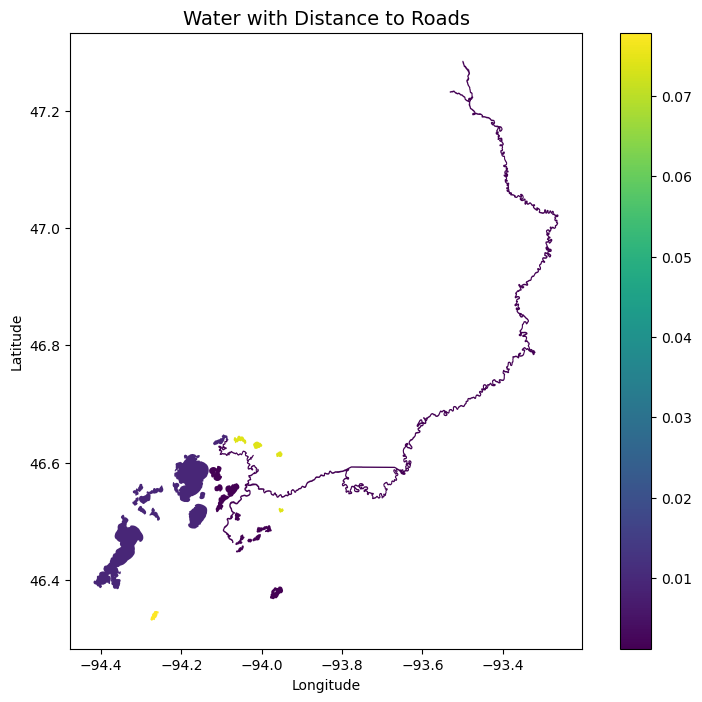

In [24]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot with colors representing 'distance_roads'
water_w_dist_final.plot(
    ax=ax, column="distance_roads", cmap="viridis", linewidth=0.5, legend=True
)

# Set titles and labels
ax.set_title("Water with Distance to Roads", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [ ]:
def export_road_dist(joined_gdf: gpd.GeoDataFrame, resolution: int = 1000):
    bounds = joined_gdf.total_bounds
    transform = rasterio.transform.from_origin(bounds[0], bounds[3], resolution, resolution)
    out_shape = (
        int(np.ceil((bounds[3] - bounds[1]) / resolution)),  
        int(np.ceil((bounds[2] - bounds[0]) / resolution))
    )
    
    column_name = "distance_roads"  # Change this to dynamically select the column if needed
    raster = rasterize(
        [(geom, value) for geom, value in zip(joined_gdf.geometry, joined_gdf[column_name])],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=rasterio.float32
    )
    
    output_filename = f"{my_path}{my_training_state}_{column_name}.tif"
    
    with rasterio.open(
        output_filename, "w",
        driver="GTiff",
        height=out_shape[0],
        width=out_shape[1],
        count=1,
        dtype=rasterio.float32,
        crs=5070,
        transform=transform
    ) as dst:
        dst.write(raster, 1)
        dst.set_band_description(1, column_name)  # Set band name
    
    # Plot the raster
    plt.figure(figsize=(10, 6))
    plt.imshow(raster, cmap='viridis', extent=[bounds[0], bounds[2], bounds[1], bounds[3]])
    plt.colorbar(label=f'{column_name}')
    plt.title('Rasterized GeoDataFrame')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [ ]:
export_road_dist(water_w_dist_final)

In [ ]:
# River Distance

In [25]:
# Function to extract vertices from each LineString/MultiLineString
def extract_vertices(geometry):
    if geometry.geom_type == "LineString":
        return list(geometry.coords)  # Extract vertices from LineString
    elif geometry.geom_type == "MultiLineString":
        return [coord for line in geometry.geoms for coord in line.coords]  # Flatten MultiLineString
    return []

def snap_points_to_nearest_line(line: gpd.GeoDataFrame, point: gpd.GeoDataFrame, snapdist: float) -> gpd.GeoDataFrame:
    """
    Snaps points to the nearest polygon within a given distance.
    
    Parameters:
        poly (GeoDataFrame): GeoDataFrame containing polygon geometries.
        point (GeoDataFrame): GeoDataFrame containing point geometries.
        snapdist (float): Maximum search distance to find the nearest polygon.
    
    Returns:
        GeoDataFrame: Updated point GeoDataFrame with snapped geometries.
    """
    # Ensure both datasets use the same projected CRS (Sweden EPSG:3006 in original, changed to 26915)
    line = line.to_crs(4269)
    point = point.set_crs(4269)
    
    # Create unique IDs
    line["lineid"] = range(line.shape[0])
    point["pointid"] = range(point.shape[0])
    
    # Store original polygon geometry
    line["linegeom"] = line.geometry
    
    # Perform spatial join to find nearest polygons within snap distance
    sj = gpd.sjoin_nearest(left_df=point, right_df=line, how="left", max_distance=snapdist)
    
    # Measure distances (set to None if no polygon within snapdistance)
    sj["distance"] = sj.apply(lambda x: x.geometry.distance(x.linegeom) if x.linegeom is not None else None, axis=1)
    
    # Sort by distance and drop duplicates (keeping closest polygon match)
    sj = sj.sort_values(by=["pointid", "distance"], ascending=True, na_position="last")
    sj = sj.drop_duplicates(subset="pointid", keep="first")
    
    # Find the nearest point on the polygon
    sj["nearestpoint"] = sj.apply(
        lambda x: nearest_points(x.geometry, x.linegeom)[1] if (x.linegeom is not None and x.distance is not None) else None,
        axis=1
    )
    
    # Snap points to nearest point on polygon if applicable
    sj["geometry"] = sj.apply(
        lambda x: snap(x.geometry, x.nearestpoint, snapdist) if x.nearestpoint is not None else x.geometry,
        axis=1
    )
    
    return sj

In [26]:
# ***If you did this earlier in your current session, you don't need to import these***
# Get NAS data
pos_data = nas_api_call_2(my_nas_id, my_training_state)
my_data = pos_data[["decimalLatitude", "decimalLongitude"]]
pos_data_gdf = gpd.GeoDataFrame(
    my_data, geometry=gpd.points_from_xy(my_data.decimalLongitude, my_data.decimalLatitude)).dropna().set_crs(4269)#.to_crs(5070)

# Import flowline

# Find all shapefiles that include "NHDFlowline_" in the filename
shapefiles = glob.glob(os.path.join(my_path + "/shape/", "*NHDFlowline_*.shp")) + glob.glob(os.path.join(my_path + "/shape/", "NHDFlowline.shp"))

# Ensure shapefiles were found
if not shapefiles:
    print("No shapefiles found matching the pattern.")

# Load all shapefiles into a list of GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shapefiles]

# Optionally, concatenate all shapefiles into a single GeoDataFrame
if gdfs:  # Only concatenate if the list is not empty
    stream_gdf = gpd.pd.concat(gdfs, ignore_index=True)
    print("Successfully merged shapefiles into a single GeoDataFrame.")
else:
    stream_gdf = None
    print("No valid shapefiles to merge.")

# Print summary
print(f"Imported {len(gdfs)} shapefiles")

Successfully merged shapefiles into a single GeoDataFrame.
Imported 1 shapefiles


In [27]:
# Apply function to extract vertices
stream_gdf["vertices"] = stream_gdf["geometry"].apply(extract_vertices)

# Convert to DataFrame with separate rows for each vertex
vertices_gdf = stream_gdf.explode("vertices", ignore_index=True)

# Convert extracted coordinates to Point geometries
vertices_gdf["geometry"] = vertices_gdf["vertices"].apply(lambda v: Point(v))

# Drop the original tuple column
vertices_gdf.drop(columns=["vertices"], inplace=True)

# Ensure the final output remains a GeoDataFrame with the correct CRS
vertices_gdf = gpd.GeoDataFrame(vertices_gdf, geometry="geometry", crs=stream_gdf.crs)

duplicate_mask = vertices_gdf.duplicated(subset=["geometry"], keep=False)
# Get only the duplicate geometries
my_vertices = vertices_gdf[duplicate_mask]


In [28]:
# Snap occurences to lines 
snapped_occ = snap_points_to_nearest_line(stream_gdf, pos_data_gdf,  10000)

C:\Users\leif.howard\AppData\Local\anaconda3\envs\masters\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


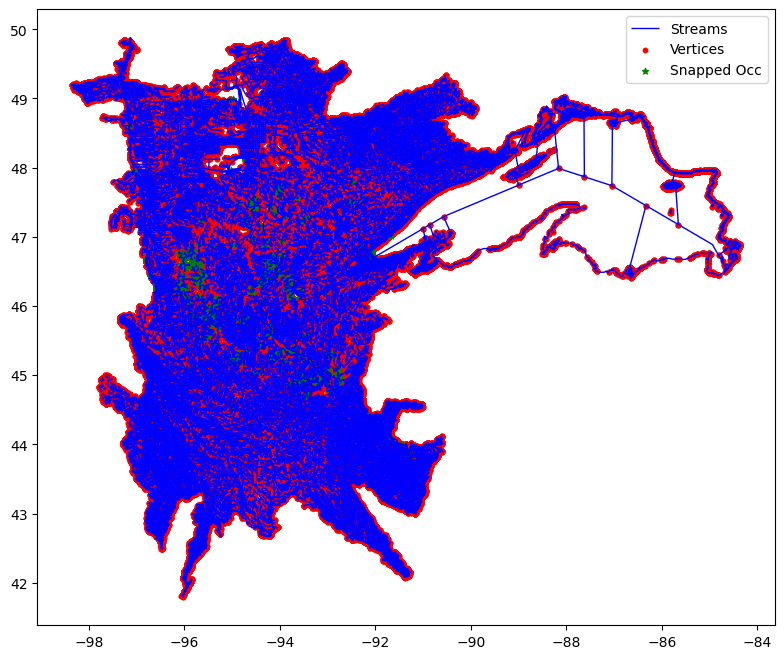

In [29]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each dataset with a different style
stream_gdf.plot(ax=ax, color="blue", linewidth=1, label="Streams")  # Line features
my_vertices.plot(ax=ax, color="red", markersize=10, label="Vertices")  # Points
snapped_occ.plot(ax=ax, color="green", markersize=20, marker="*", label="Snapped Occ")  # Highlighted points

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [30]:
joined = gpd.sjoin_nearest(my_vertices, snapped_occ.drop(columns=["index_right"], errors="ignore"), how="left")

C:\Users\leif.howard\AppData\Local\anaconda3\envs\masters\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [ ]:
# Load the shapefiles
source_gdf = my_vertices.to_crs(3857)
target_gdf = snapped_occ.to_crs(3857)
network_gdf = stream_gdf.to_crs(3857)

# Ensure all GeoDataFrames use the same CRS
if not (source_gdf.crs == target_gdf.crs == network_gdf.crs):
    target_gdf = target_gdf.to_crs(source_gdf.crs)
    network_gdf = network_gdf.to_crs(source_gdf.crs)

# Build a graph from the polyline network
def build_network(gdf):
    G = nx.Graph()
    for _, row in gdf.iterrows():
        line = row.geometry
        if isinstance(line, LineString):
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                G.add_edge(
                    coords[i],
                    coords[i + 1],
                    weight=Point(coords[i]).distance(Point(coords[i + 1]))
                )
    return G

network_graph = build_network(network_gdf)

# Snap a point to the nearest point on the network
def snap_point_to_network(point, network_gdf, graph):
    nearest_line = network_gdf.loc[network_gdf.distance(point).idxmin()]
    snapped_point = nearest_points(point, nearest_line.geometry)[1]
    snapped_coords = (snapped_point.x, snapped_point.y)
    
    coords = list(nearest_line.geometry.coords)
    for i in range(len(coords) - 1):
        start, end = coords[i], coords[i + 1]
        segment = LineString([start, end])
        if segment.distance(snapped_point) < 1e-6:
            graph.add_edge(start, snapped_coords, weight=Point(start).distance(snapped_point))
            graph.add_edge(snapped_coords, start, weight=Point(start).distance(snapped_point))
            graph.add_edge(end, snapped_coords, weight=Point(end).distance(snapped_point))
            graph.add_edge(snapped_coords, end, weight=Point(end).distance(snapped_point))
            break
    return snapped_coords

# Identify connected and disconnected point pairs
def identify_connected_disconnected_pairs(point_pairs, source_gdf, target_gdf, network_gdf, network_graph):
    connected_pairs = []
    disconnected_pairs = []
    
    for pair in point_pairs:
        source_id, target_id = pair
        
        source_geom = source_gdf[source_gdf["ObjectID"] == source_id].iloc[0].geometry
        target_geom = target_gdf[target_gdf["ObjectID"] == target_id].iloc[0].geometry
        
        source_node = snap_point_to_network(source_geom, network_gdf, network_graph)
        target_node = snap_point_to_network(target_geom, network_gdf, network_graph)
        
        if nx.has_path(network_graph, source_node, target_node):
            connected_pairs.append((pair, source_node, target_node))
        else:
            disconnected_pairs.append(pair)
    
    return connected_pairs, disconnected_pairs

# Load point pairs
point_pairs = joined[['ObjectID_left', 'ObjectID_right']].to_numpy()
#point_pairs = point_pairs[:100]
# Separate point pairs into connected and disconnected
connected_pairs, disconnected_pairs = identify_connected_disconnected_pairs(
    point_pairs, source_gdf, target_gdf, network_gdf, network_graph
)


In [44]:
# Calculate shortest distances for connected point pairs
def calculate_shortest_distances(connected_pairs, network_graph):
    results = []
    for pair, source_node, target_node in connected_pairs:
        source_id, target_id = pair
        
        path_length = nx.shortest_path_length(
            network_graph, source_node, target_node, weight="weight"
        )
        
        results.append({
            "source_point_id": source_id,
            "target_point_id": target_id,
            "distance_river": path_length
        })
    return results

# Add disconnected pairs with "inf" distances
def add_disconnected_pairs_to_results(disconnected_pairs):
    return [
        {"source_point_id": pair[0], "target_point_id": pair[1], "distance_river": float("inf")}
        for pair in disconnected_pairs
    ]

# Step 1: Calculate shortest distances for connected pairs
connected_distances = calculate_shortest_distances(connected_pairs, network_graph)

# # Step 2: Add disconnected pairs
# disconnected_distances = add_disconnected_pairs_to_results(disconnected_pairs)

# # Step 3: Combine results
# all_distances = connected_distances + disconnected_distances

# Convert results to a DataFrame
results_df = pd.DataFrame(connected_distances)

# Print or save the results
print(results_df)
# results_df.to_csv("carp_distances.csv", index=False)


    source_point_id  target_point_id  distance_river
0                 1           152949    82402.308297
1                 1           152949    82402.308297
2                 2           220601    39474.120888
3                 2           220601    39474.120888
4                 3             7944     9863.589331
..              ...              ...             ...
86               55           306510     1364.987757
87               55           306510     1364.987757
88               56           211134    32382.566155
89               57           241104    88022.944804
90               57           241104    88022.944804

[91 rows x 3 columns]


In [45]:
points_w_dist = pd.merge(source_gdf, results_df, left_on = 'ObjectID', right_on = 'source_point_id', how = 'inner')

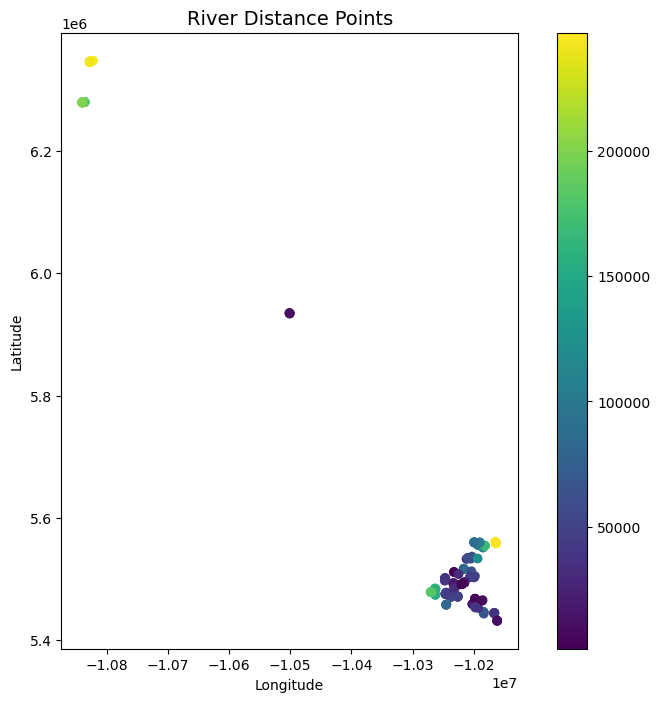

In [46]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot with colors representing 'distance_roads'
points_w_dist.plot(
    ax=ax, column="distance_river", cmap="viridis", legend=True
)

# Set titles and labels
ax.set_title("River Distance Points", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [47]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize

# Load the shapefile
waterbodies = buffered_water

# Define raster parameters
raster_meta = {
    'driver': 'GTiff',
    'dtype': 'uint8',
    'nodata': 0,
    'count': 1,
    'crs': waterbodies.crs,
    'transform': rasterio.transform.from_bounds(*waterbodies.total_bounds, width=500, height=500),  # Adjust resolution
    'width': 500,  # Set the number of columns
    'height': 500   # Set the number of rows
}

# Rasterize: Assign 1 to pixels inside waterbodies
raster_data = np.zeros((raster_meta['height'], raster_meta['width']), dtype=np.uint8)
shapes = [(geom, 1) for geom in waterbodies.geometry]
rasterized = rasterize(shapes, out=raster_data, transform=raster_meta['transform'])

# Save raster
with rasterio.open("waterbody_raster.tif", "w", **raster_meta) as dst:
    dst.write(rasterized, 1)


In [49]:
from scipy.spatial import cKDTree

# Load points with values
points = points_w_dist

# Convert point geometries to arrays
point_coords = np.array([[p.x, p.y] for p in points.geometry])
point_values = np.array(points['distance_river'])  # Assuming 'value' column exists

# Get coordinates of water pixels
rows, cols = np.where(rasterized == 1)
x_coords, y_coords = rasterio.transform.xy(raster_meta['transform'], rows, cols)

# Build KDTree for nearest neighbor search
tree = cKDTree(point_coords)

# Find nearest point and get its value
distances, indices = tree.query(np.column_stack((x_coords, y_coords)))
nearest_values = point_values[indices]

# Create final raster with nearest values where waterbody = 1
final_raster = np.zeros_like(rasterized, dtype=float)
final_raster[rasterized == 1] = nearest_values

# Save the final raster
raster_meta.update(dtype='float32', nodata=-9999)
with rasterio.open("river_distance.tif", "w", **raster_meta) as dst:
    dst.write(final_raster, 1)


In [ ]:
# Combine all the predictors you just created and export a final combined raster 
# Define input files
input_files = [
    my_path + "ca.tif", my_path + "pH.tif", my_path + "di_N.tif", my_path + "do.tif", my_path + "phos.tif", 
    my_path + my_training_state + "_rsd.tif", my_path + my_training_state + "_inv_richness.tif", 
    my_path + my_training_state + "_Native_Fish_Richness.tif", my_path + 'mess_output.tif',
    my_path + 'river_distance.tif', my_path + 'road_distance.tif']
#Combine rasters into a multi-band GeoTIFF
output_file = my_path + my_training_state + "_combined.tif" # this will replace the other combined tif you made.
combine_geotiffs(input_files, output_file, state)

print(f"✅ Multi-band raster saved as {output_file}")